In [1]:
import numpy as np
import tqdm 
import osyris
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys

sys.path.append('../my_funcs/')
from pipeline_main import pipeline, dist

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

In [2]:
def to_osyris(self, ivs = 'd', view = 200, dz = None, resolution = 400, viewpoint = None, ivs_unit = 'g/cm^3', make_plot = False):
    selection_radius =  (np.sqrt(2 * (0.5*view)**2) * 1.2)/ self.au_length # Not all data is needed to be read for a single slap of data

    print('Looping over DISPATCH data to extract data at highest level')
    pp = [p for p in self.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
    w= np.array([p.level for p in pp]).argsort()[::-1]
    sorted_patches = [pp[w[i]] for i in range(len(pp))]

    patch_cartcoor = []
    patch_ds = []
    patch_values = []
    for p in tqdm.tqdm(sorted_patches):
        nbors = [self.sn.patchid[i] for i in p.nbor_ids if i in self.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]
        if len(leafs) == 8: continue
        to_extract = np.ones(p.n, dtype=bool)
        for lp in leafs:
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool

        new_xyz = p.rel_xyz[:,to_extract].T
        new_value = p.var(ivs)[to_extract].T

        patch_ds.extend(p.ds[0] * np.ones(len(new_value)))
        patch_cartcoor.extend(new_xyz.tolist())
        patch_values.extend(new_value.tolist())
    
    patch_ds = np.asarray(patch_ds)
    patch_cartcoor = np.asarray(patch_cartcoor)
    patch_values = np.asarray(patch_values)

    print('Setting up Osyris data structure')
    ds = osyris.Dataset(nout = None)
    # overwrite units
    ds.meta['unit_l'] = self.sn.scaling.l
    ds.meta['unit_t'] = self.sn.scaling.t
    ds.meta['unit_d'] = self.sn.scaling.d
    ds.set_units()
    ds.meta["ndim"] = 3

    if viewpoint == None: viewpoint = self.L
    to_view = osyris.Vector(x=viewpoint[0],y=viewpoint[1],z=viewpoint[2])

    ds['amr'] = osyris.Datagroup()
    ds['amr']['dx'] = osyris.Array(patch_ds*self.sn.scaling.l, unit='cm')
    ds['amr']['position'] = osyris.Vector(x=patch_cartcoor[:,0]*self.sn.scaling.l, y=patch_cartcoor[:,1]*self.sn.scaling.l, z=patch_cartcoor[:,2]*self.sn.scaling.l, unit='cm')
    ds['hydro'] = osyris.Datagroup()
    ds['hydro']['density'] = osyris.Array(patch_values, unit='dimensionless')

    view *= osyris.units('au')
    if dz == None: dz = 0.1 * view
    else: dz *= osyris.units('au')
    center = osyris.Vector(x=0,y=0,z=0,unit='au')

    ret = osyris.map({"data": ds['hydro']['density'], "norm": "log"}, dx=view, dz = dz, origin=center, resolution=resolution, direction=to_view, plot=make_plot)

    plot_height = dz / osyris.units('au') * self.sn.cgs.au
    print(plot_height)
    return ret.layers[0]['data'] #/ plot_height

pipeline.to_osyris = to_osyris

In [3]:
data = pipeline(snap = 375, run = 'my_core_sink82')
data.recalc_L(verbose = 1); 

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1266.30it/s]


Converged mean angular momentum vector after 0 iteration(s)


In [4]:
density = data.to_osyris()

Looping over DISPATCH data to extract data at highest level


  0%|          | 0/1195 [00:00<?, ?it/s]

100%|██████████| 1195/1195 [00:04<00:00, 261.46it/s]


Setting up Osyris data structure
299200000000000.0 dimensionless


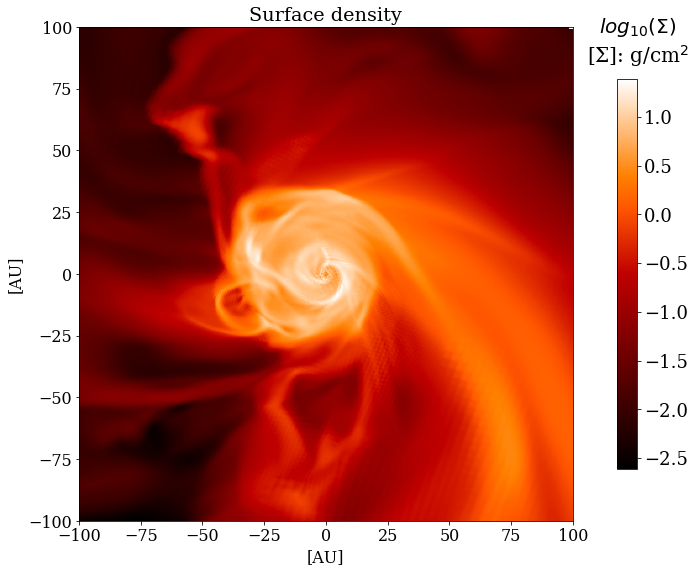

In [5]:
fig, axs = plt.subplots(figsize = (10, 10))
cs = axs.imshow(np.log10(density * data.cgs_density), extent = (-100, 100, -100, 100), origin ='lower', cmap = 'gist_heat')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.08);
cbar.ax.xaxis.set_label_coords(-10, -10)
cbar.set_label('$log_{10}(Σ)$\n[Σ]: g/cm$^2$', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20)
axs.set(title = 'Surface density', ylabel = '[AU]', xlabel = '[AU]')
cbar.ax.tick_params(labelsize=18)

In [39]:
def to_osyris_ivs(self, variables, view = 200, dz = None, resolution = 400, viewpoint = None):
    selection_radius =  (np.sqrt(2 * (0.5*view)**2) * 1.2)/ self.au_length # Not all data is needed to be read for a single slap of data

    print('Looping over DISPATCH data to extract data at highest level')
    pp = [p for p in self.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
    w= np.array([p.level for p in pp]).argsort()[::-1]
    sorted_patches = [pp[w[i]] for i in range(len(pp))]

    patch_cartcoor = []
    patch_ds = []
    patch_values = {key: [] for key in range(len(variables))}
    self.osyris_ivs = {key: [] for key in range(len(variables))}
    for p in tqdm.tqdm(sorted_patches):
        nbors = [self.sn.patchid[i] for i in p.nbor_ids if i in self.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]
        if len(leafs) == 8: continue
        to_extract = np.ones(p.n, dtype=bool)
        for lp in leafs:
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool

        #Looping over the data to extract from DISPATCH
        for i, ivs in enumerate(variables):
            new_value = p.var(ivs)[to_extract].T
            patch_values[i].extend(new_value.tolist())
        
        #Extracting the position and cellsize data each is fixed across all data
        new_xyz = p.rel_xyz[:,to_extract].T
        patch_ds.extend(p.ds[0] * np.ones(len(new_value)))
        patch_cartcoor.extend(new_xyz.tolist())
        
    
    patch_ds = np.asarray(patch_ds)
    patch_cartcoor = np.asarray(patch_cartcoor)
    for key in patch_values:
        patch_values[key] = np.array(patch_values[key])

    print('Setting up Osyris data structure')
    ds = osyris.Dataset(nout = None)
    # overwrite units
    ds.meta['unit_l'] = self.sn.scaling.l
    ds.meta['unit_t'] = self.sn.scaling.t
    ds.meta['unit_d'] = self.sn.scaling.d
    ds.set_units()
    ds.meta["ndim"] = 3

    if viewpoint == None: viewpoint = self.L
    to_view = osyris.Vector(x=viewpoint[0],y=viewpoint[1],z=viewpoint[2])

    view *= osyris.units('au')
    if dz == None: dz = 0.1 * view
    else: dz *= osyris.units('au')
    center = osyris.Vector(x=0,y=0,z=0,unit='au')
    plot_height = dz / osyris.units('au') * self.sn.cgs.au

    ds['amr'] = osyris.Datagroup()
    ds['amr']['dx'] = osyris.Array(patch_ds*self.sn.scaling.l, unit='cm')
    ds['amr']['position'] = osyris.Vector(x=patch_cartcoor[:,0]*self.sn.scaling.l, y=patch_cartcoor[:,1]*self.sn.scaling.l, z=patch_cartcoor[:,2]*self.sn.scaling.l, unit='cm')
    ds['hydro'] = osyris.Datagroup()
    for i, ivs in enumerate(variables):
        ds['hydro'][f'{i}'] = osyris.Array(patch_values[i], unit = 'dimensionless')
        ret = osyris.map({"data": ds['hydro'][f'{i}'], "norm": "log"}, dx=view, dz = dz, origin=center, resolution=resolution, direction=to_view, plot=False)
        if ivs == 'd': self.osyris_ivs[i] = ret.layers[0]['data']
        else:
            self.osyris_ivs[i] = ret.layers[0]['data'] / plot_height

pipeline.to_osyris_ivs = to_osyris_ivs

In [40]:
# List containing the ivs string values to extract from patches
variable = ['(bx**2 + by**2 + bz**2)**0.5', 'd', '((px**2+py**2+pz**2)**0.5 / d)**0.5']
for i, ivs in enumerate(variable):
    print(i, ivs)

0 (bx**2 + by**2 + bz**2)**0.5
1 d
2 ((px**2+py**2+pz**2)**0.5 / d)**0.5


In [41]:
data.to_osyris_ivs(variables=variable)

Looping over DISPATCH data to extract data at highest level


  4%|▍         | 45/1195 [00:00<00:02, 449.97it/s]

100%|██████████| 1195/1195 [00:04<00:00, 241.81it/s]


Setting up Osyris data structure


/groups/astro/kxm508/.local/lib/python3.8/site-packages/numpy/ma/core.py:711: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(a, copy=False, subok=subok)


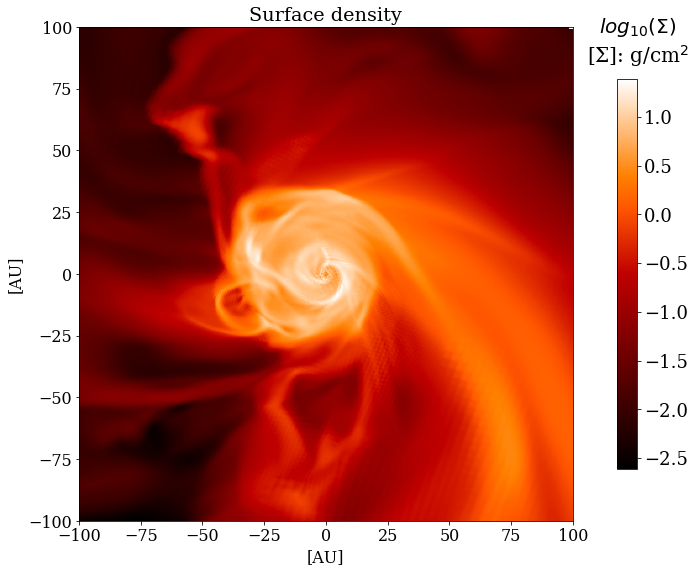

In [42]:
fig, axs = plt.subplots(figsize = (10, 10))
cs = axs.imshow(np.log10(data.osyris_ivs[1] * data.cgs_density), extent = (-100, 100, -100, 100), origin ='lower', cmap = 'gist_heat')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.08);
cbar.ax.xaxis.set_label_coords(-10, -10)
cbar.set_label('$log_{10}(Σ)$\n[Σ]: g/cm$^2$', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20)
axs.set(title = 'Surface density', ylabel = '[AU]', xlabel = '[AU]')
cbar.ax.tick_params(labelsize=18)

# The strength of the magnetic field seems a bit high - could be a bug somewhere

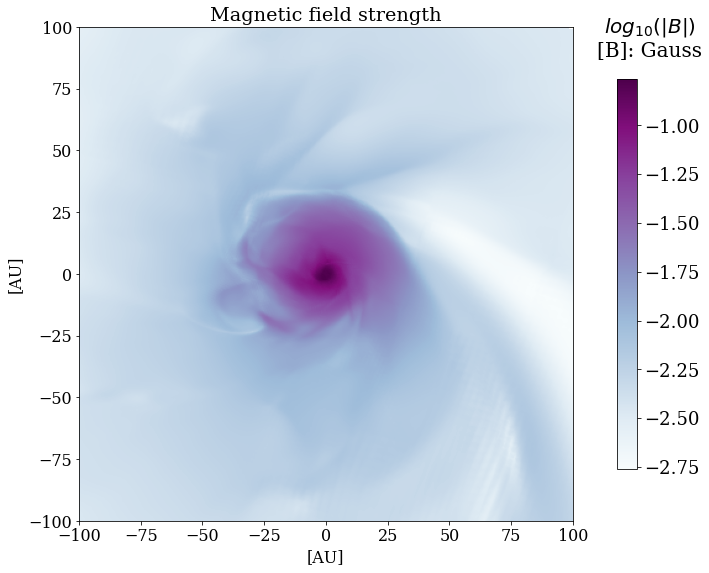

In [43]:
fig, axs = plt.subplots(figsize = (10, 10))
cs = axs.imshow(np.log10((data.osyris_ivs[0]) *data.sn.scaling.b), extent = (-100, 100, -100, 100), origin ='lower', cmap = 'BuPu')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.08);
cbar.ax.xaxis.set_label_coords(-10, -10)
cbar.set_label('$log_{10}(|B|)$\n[B]: Gauss', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20)
axs.set(title = 'Magnetic field strength', ylabel = '[AU]', xlabel = '[AU]')
cbar.ax.tick_params(labelsize=18)

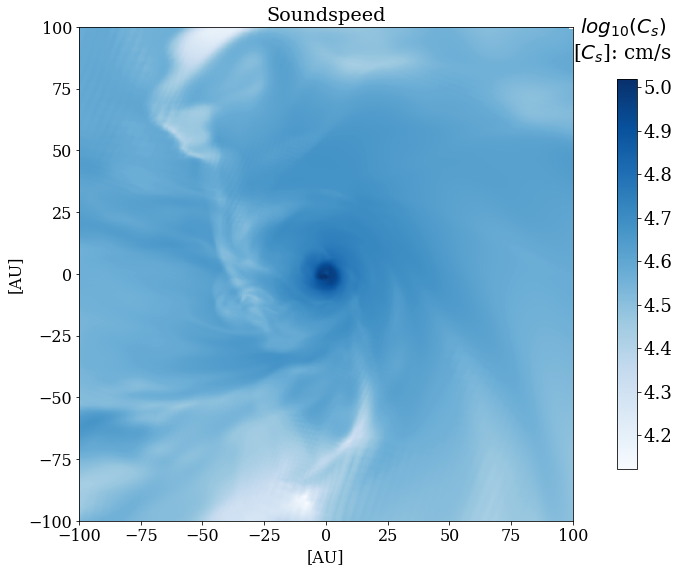

In [44]:
fig, axs = plt.subplots(figsize = (10, 10))
cs = axs.imshow(np.log10((data.osyris_ivs[2]) * data.cms_velocity), extent = (-100, 100, -100, 100), origin ='lower', cmap = 'Blues')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.08);
cbar.ax.xaxis.set_label_coords(-10, -10)
cbar.set_label('$log_{10}(C_s)$\n[$C_s$]: cm/s', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20)
axs.set(title = 'Soundspeed', ylabel = '[AU]', xlabel = '[AU]')
cbar.ax.tick_params(labelsize=18)